In [95]:
#import
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from joblib import load
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import time
import os
import sys
import math
from scipy import stats

# Step 1
(1) Load model and trading dataset
(2) Predict data with choosen probability threshold
(3) Save predictions for later use

In [17]:
#Load dataset and pick relevant columns
load_dataset = pd.read_json('./trading_dataset.json')
dataset = pd.DataFrame()
dataset['date_time']=load_dataset.date_time
dataset['text']=load_dataset.text
dataset['company']=load_dataset.company
dataset['RIC']=load_dataset.RIC
dataset['beta']=load_dataset.beta
dataset['old_before']=load_dataset.before_price
dataset['old_after'] = load_dataset.after_price

#Load models and calculate probabilities

X = dataset.text

tfidf = load('./tfidf_05dataset.joblib')
X_transformed = tfidf.transform(X)

logreg = load('./logreg_05dataset.joblib')
y_pred_proba = logreg.predict_proba(X_transformed)

y_probabilities = pd.DataFrame(y_pred_proba, columns=['Down', 'Stable', 'Up'])

#Classify instances based on probabilities and choosen threshold 
def predict(threshold, probabilities):
    for row in range(len(probabilities)):
        if probabilities.iloc[row].Stable > probabilities.iloc[row].Down and probabilities.iloc[row].Stable > probabilities.iloc[row].Up:
            probabilities.loc[row, 'predicted'] = 'Stable'
        
        elif probabilities.iloc[row].Down>threshold and probabilities.iloc[row].Down>probabilities.iloc[row].Up:
            probabilities.loc[row, 'predicted'] = 'Down'
            
        elif probabilities.iloc[row].Up>threshold and probabilities.iloc[row].Up>probabilities.iloc[row].Down:
            probabilities.loc[row, 'predicted'] = 'Up'
            
        else:
            probabilities.loc[row, 'predicted'] = 'Stable'
    
    return probabilities


threshold=0.43
probabilities = predict(threshold, y_probabilities)
y_pred = probabilities.predicted
dataset['Predicted'] = y_pred

thold = str(threshold).split('.')
jpath = './dataset/predicted_' + thold[1] + 'percent.json'

dataset.to_json(jpath)

dataset.Predicted.value_counts()

Up        174
Down      144
Stable    143
Name: Predicted, dtype: int64

Descriptive data of the text dataset

In [81]:
desc = pd.read_json('./trading_dataset.json')

{'whiskers': [<matplotlib.lines.Line2D at 0x1318e0c90>,
 'caps': [<matplotlib.lines.Line2D at 0x1318e0610>,
 'boxes': [<matplotlib.lines.Line2D at 0x12d3220d0>],
 'medians': [<matplotlib.lines.Line2D at 0x14bbef410>],
 'fliers': [<matplotlib.lines.Line2D at 0x14bbe87d0>],
 'means': []}

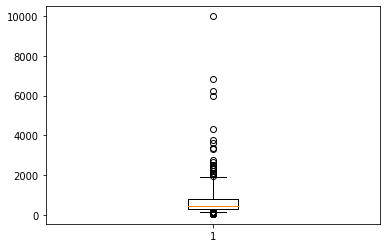

In [93]:
from sklearn.preprocessing import RobustScaler
from matplotlib.pyplot import boxplot


my_list = np.array(list(desc.text.str.split().apply(len)))
boxplot(my_list, whis=[5,95], showfliers=True)

In [96]:
stats.describe(my_list)

DescribeResult(nobs=461, minmax=(49, 9986), mean=693.8026030368763, variance=717263.6631236442, skewness=5.550316910408496, kurtosis=44.18375370568737)

In [109]:
np.percentile(my_list, 95)

1899.0

In [112]:
my_list.sum()

319843

In [213]:
desc.RIC.value_counts()

SKAb.ST     14
SSM.ST      12
RECIb.ST    10
TELIA.ST     9
SBBd.ST      7
            ..
DURCb.ST     1
ORTIb.ST     1
BIOAb.ST     1
NEWAb.ST     1
SWECb.ST     1
Name: RIC, Length: 223, dtype: int64

# Step 2
(1) Load predictions from Step 1
(2) Merge with trading ids to find stock data

In [2]:
def load_data(threshold):
    prob_threshold = str(threshold)
    d_path = './dataset/predicted_' + prob_threshold + 'percent.json'
    dataset = pd.read_json(d_path)


    #Load IDs to match with stocks and create unique key
    trading_id = pd.read_csv('./trading_id05.csv', sep=';')
    trading_id['key'] = None
    for k in range (len(trading_id)):
        t = trading_id.date_time.iloc[k]
        trading_id.key.iloc[k] = t + '-' + trading_id.RIC.iloc[k]

    #Drop rows with stable
    dataset = dataset[dataset.Predicted != 'Stable']

    ##Match key to add ID to dataset    
    dataset['key'] = None
    dataset['id'] = None
    dataset['error'] = None
    dataset['nasdaq'] = None

    #Create key
    for k in range (len(dataset)):
        t = dataset.date_time.iloc[k].to_pydatetime()
        dataset.key.iloc[k] = t.strftime("%Y-%m-%d %H:%M:%S") + '-' + dataset.RIC.iloc[k]

    #Match key and add ID and ERROR to dataset
    for j in range (len(dataset)):
        index = trading_id.loc[trading_id['key'] == dataset.key.iloc[j]].index[0]
        dataset.id.iloc[j] = trading_id.id.loc[index]
        dataset.error.iloc[j] = trading_id.error.loc[index]
        dataset.nasdaq.iloc[j] = trading_id.nasdaq.loc[index]

    #Drop key
    dataset = dataset.drop(['key'], axis=1)


    ##FIND TRADING TIME ETC.    
    closing = 17.5 * 60 * 60 * 1000000000

    trading = pd.DataFrame(dataset)
    #trading = pd.read_csv('./trading_id.csv', sep=';')

    #Create time in seconds from 00:00:00 to match with stock data
    trading['time'] = None
    for index in range (len(trading)):
        trading_date_time = str(trading.date_time.iloc[index]).split(' ')
        h,m,s = trading_date_time[1].split(':')
        trading_time = int(timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds()) * 1000000000
        if trading_time < closing:
            trading.time.iloc[index] = trading_time
        else: 
            trading.time.iloc[index] = 0
    #Sort values in ascending order from first date
    trading = trading.sort_values(by='date_time', ascending=True)
    return(trading)


# Run trading strategy with hourly data
(1) Load stock data


In [282]:
#Load stock data and fill na
stocks = pd.read_excel('./stocks.xlsx')
stocks = stocks.fillna(pd.Timestamp(1970,1,1))

#Load OMX data and create a timestamp
omx = pd.read_csv('./omx.csv')
omx['timestamp'] = None
for f in range (len(omx)):
    omx.timestamp.iloc[f] = pd.Timestamp(omx.Timestamp.iloc[f])

(2) Locate trade and close price for each trade

In [283]:
threshold = 44
noid = load_data(threshold)


def find_open_price(g, trade_time):
    path = './Nasdaq/'+ str(noid.nasdaq.iloc[g]) +'-2020-01-01-2020-03-12.csv'
    load_open_price = pd.read_csv(path, sep=';', header=[1])
    open_price = pd.DataFrame()
    open_price['Date'] = load_open_price['Date']
    open_price['opening_price'] = load_open_price['Opening price']
    trade_index = min(enumerate(open_price.Date), key=lambda x: abs(pd.Timestamp(x[1])-trade_time))
    trade_price = float(open_price.loc[trade_index[0], 'opening_price'].replace(',','.'))
    trade_index = pd.Timestamp(trade_index[1]) + timedelta(hours=9)
    return (trade_price, trade_index)


#Create new columns in dataframe
noid['pre_price'] = None
noid['post_price'] = None
noid['rm'] = None
noid['trade_time'] = None


for g in range (len(noid)):
    #Find trade time
    trade_time = pd.Timestamp(noid.date_time.iloc[g])
    loc_price = noid.RIC.iloc[g] + ' Trade Close'
    loc_ric = noid.RIC.iloc[g] + ' Timestamp'

    #Check if time is before open and choose open price or hour price. 
    
    if datetime.time(trade_time) < time(hour=9) and pd.notnull(noid.nasdaq.iloc[g]) is True:
        trade_time = trade_time.replace(hour=9, minute=0)
        trade_price, trading_time = find_open_price(g, trade_time)
    elif datetime.time(trade_time) > time(hour=17) and pd.notnull(noid.nasdaq.iloc[g]) is True:
        trade_time = trade_time + timedelta(hours=24)
        trade_time = trade_time.replace(hour=9, minute=0)
        trade_price, trading_time = find_open_price(g, trade_time)
    elif datetime.time(trade_time) > time(hour=17) and pd.notnull(noid.nasdaq.iloc[g]) is False:
        trade_time = trade_time + timedelta(hours=24)
        trade_time = trade_time.replace(hour=9, minute=0)
        trade_index = min(enumerate(stocks[loc_ric]), key=lambda x: abs(x[1]-trade_time))
        trade_price = stocks.loc[trade_index[0], loc_price]
        trading_time = trade_index[1]
        trade_index = trade_index[0]

    else:
        trade_index = min(enumerate(stocks[loc_ric]), key=lambda x: abs(x[1]-trade_time))
        trading_time = trade_index[1] 
        if trading_time < trade_time:
            trade_index = trade_index[0] - 1
            trading_time = stocks.loc[trade_index, loc_ric] 
        else:
            trading_time = trade_index[1] 
            trade_index = trade_index[0]
        trade_price = stocks.loc[trade_index, loc_price]
        
    #Find price of corresponding time from above at trade and closing of trade
    
    post_time = trading_time + timedelta(hours=1)
    post_index = min(enumerate(stocks[loc_ric]), key=lambda x: abs(x[1]-post_time))
    post_price = stocks.loc[post_index[0], loc_price]
    
    #Find and calculate market change
    trade_omx_index = min(enumerate(omx.timestamp), key=lambda x: abs(x[1]-trading_time))
    post_omx_index = min(enumerate(omx.timestamp), key=lambda x: abs(x[1]-post_time))

    rm = omx.p_change.loc[post_omx_index[0]] / omx.p_change.loc[trade_omx_index[0]] - 1
    
    noid.pre_price.iloc[g] = trade_price
    noid.post_price.iloc[g] = post_price
    noid.rm.iloc[g] = rm
    
    noid.trade_time.iloc[g] = trading_time
    
    
#Calculate returns of trades.
# If up = actual returns
# If down = returns of short
noid['returns_pm'] = None
noid['returns_index'] = None
noid['returns_alpha'] = None
noid['returns_old'] = None

for j in range (len(noid)):
    if noid.Predicted.iloc[j] == 'Down':
        pm = noid.pre_price.iloc[j] / noid.post_price.iloc[j]
        im = pm - 1 + noid.rm.iloc[j]
        bm = pm - 1 + noid.beta.iloc[j] * noid.rm.iloc[j] 
        old = noid.old_before.iloc[j] / noid.old_after.iloc[j]
    elif noid.Predicted.iloc[j] == 'Up':
        pm = noid.post_price.iloc[j] / noid.pre_price.iloc[j]
        im = pm - 1 - noid.rm.iloc[j]
        bm = pm - 1 - noid.beta.iloc[j] * noid.rm.iloc[j] 
        old = noid.old_after.iloc[j] / noid.old_before.iloc[j]
    else:
        pass
    noid.returns_pm.iloc[j] = pm
    noid.returns_index.iloc[j] = im + 1
    noid.returns_alpha.iloc[j] = bm + 1
    noid.returns_old.iloc[j] = old
    
noid_path = './trading_results/final_trading_hour_t' + str(threshold) + '.json'
noid.to_json(noid_path)

noid.head(5)


337


,date_time,text,company,RIC,beta,old_before,old_after,Predicted,id,error,nasdaq,time,pre_price,post_price,rm,trade_time,returns_pm,returns_index,returns_alpha,returns_old
459,2020-01-02 08:00:00,I enlighet med artikel 19 i EU:s marknadsmissb...,nordic waterproofing holding a/s,NWGH.ST,-0.201321,96.20,97.40,Down,1.58884e+12,NaN,NWG,28800000000000,96.5,98,0.00997009,2020-01-02 09:00:00,0.984694,0.994664,0.982687,0.98768
458,2020-01-02 12:00:00,Kristina Lukes har rekryterats som ny VD på Ne...,qliro group ab,QLRO.ST,0.329902,7.40,7.50,Down,1.58927e+12,NaN,QLRO,43200000000000,7.05,7.28,9.82898e-05,2020-01-02 12:00:00,0.968407,0.968505,0.968439,0.986667
456,2020-01-03 08:00:00,Den 2 januari 2020 förvärvade Drew Technologie...,opus group ab,OPUS.ST,-1.329437,8.38,8.38,Down,1.58884e+12,NaN,OPUS,28800000000000,8.39,8.37,-0.00533199,2020-01-03 09:00:00,1.00239,0.997057,1.00948,1
455,2020-01-03 08:30:00,INVISIO publicerar en omvänd vinstvarning med ...,invisio communications ab,IVSO.ST,0.164096,102.00,118.20,Up,1.58884e+12,ERROR,IVSO,30600000000000,127,118.2,-0.00533199,2020-01-03 09:00:00,0.930709,0.936041,0.931584,1.15882
454,2020-01-07 07:00:00,Valutaeffekten netto av Kindred Groups viktiga...,kindred group plc,KINDsdb.ST,1.009737,57.46,57.16,Down,1.58927e+12,NaN,KIND-SDB,25200000000000,57.7,57.3,0.00349895,2020-01-07 09:00:00,1.00698,1.01048,1.01051,1.00525


In [118]:
noid.Predicted.value_counts()

Up      215
Down    193
Name: Predicted, dtype: int64

(4) Calculate cumulative returns and visiualize it in a graph

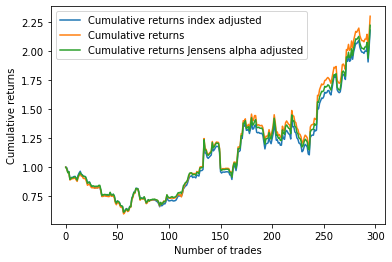

In [212]:
##Calculate cumulative returns of trading strategy
cu_im = [1]
cu_pm = [1]
cu_bm = [1]
cu_old = [1]


for l in range (len(noid)):
    im = noid.returns_index.iloc[l]
    cu_im.append(cu_im[l] * im)
    pm = noid.returns_pm.iloc[l]
    cu_pm.append(cu_pm[l] * pm)
    bm = noid.returns_alpha.iloc[l]
    cu_bm.append(cu_bm[l] * bm)
    old = noid.returns_old.iloc[l]
    cu_old.append(cu_old[l] * old)

##Plot cummulative returns of trading strategy
x_label = []
for i in range (len(cu_im)):
    x_label.append(i)
plt.plot(x_label, cu_im, label='Cumulative returns index adjusted')
plt.plot(x_label, cu_pm, label='Cumulative returns')
plt.plot(x_label, cu_bm, label='Cumulative returns Jensens alpha adjusted')
#plt.plot(x_label, cu_old, label='Cummulative returns daily data')
plt.ylabel('Cumulative returns')
plt.xlabel('Number of trades')
plt.legend()
plt.savefig('./returns_45th_05set')
plt.show()


(5) Run regression analysis of trades

In [28]:
x = []
y = []
for i in range(len(noid)):
    y.append(noid.returns_pm.iloc[i]-1)
    x.append(noid.rm.iloc[i])
    
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.427
Date:                Tue, 12 May 2020   Prob (F-statistic):             0.0205
Time:                        22:35:59   Log-Likelihood:                 568.61
No. Observations:                 295   AIC:                            -1133.
Df Residuals:                     293   BIC:                            -1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.460      0.6

Export results

In [29]:
std = pd.DataFrame()
std['returns_alpha'] = noid['returns_alpha']
std['ra'] = None
for i in range (len(std)):
    std.ra.iloc[i] = (std.returns_alpha.iloc[i] -1)

results = pd.read_json('./t_results.json')

#results = pd.DataFrame()
#results['prob_threshold'] = None
#results['std']= None
#results['mean'] = None
#results['t_value'] = None
#results['trades'] = None
#results['data'] = None

index = len(results)
print(index)

std_final = std.std(axis=0)
mean = std.ra.mean()
results.loc[index, 'std'] = std_final.ra
results.loc[index,'mean'] = mean
results.loc[index,'t_value'] = (mean * math.sqrt(len(std))) / std_final.ra
results.loc[index, 'prob_threshold'] = 44
results.loc[index, 'trades'] = len(std)
results.loc[index, 'data'] = 'Hourly'
results.to_json('./t_results.json')
results.head(12)

10


,prob_threshold,std,mean,t_value,trades,data
0,50,0.036194,0.002284,0.798278,160,Hourly
1,45,0.035425,0.002848,1.343007,279,Hourly
2,33,0.037719,0.001995,1.068166,408,Hourly
3,60,0.039643,-0.003048,-0.461295,36,Hourly
4,45,0.034203,0.002102,0.784798,163,Minute - 1 sec delay
5,45,0.028690,-0.000618,-0.275147,163,Minute - 60 sec delay
6,45,0.034203,0.002102,0.784798,163,Minute - 1.0 sec delay
7,45,0.034437,0.002287,0.847921,163,Minute - 0.1 sec delay
8,44,0.034347,0.002837,1.095832,176,Minute - 1.0 sec delay
9,44,0.034621,0.003112,1.192329,176,Minute - 0.1 sec delay


# Run returns with tick data
(1) Locate trade and close price
(2) Calculate returns

In [233]:
threshold = 44
trading = load_data(threshold)

#60 Seconds delay from publication to trade (to nanoseconds)
delay = 1 * 1000000000
#60 Minutes holding period (to nanoseconds)
holding = 60 * 60 * 1000000000

#Create new columns in dataframe
trading['pre_price'] = None
trading['post_price'] = None
trading['rm'] = None
trading['trade_time'] = None

error = []

#Clean dataset
trading = trading[trading.Predicted != 'Stable']
trading = trading.dropna(subset=['id'])
trading = trading[trading.error != 'ERROR']

#Load market data
omx = pd.read_csv('./omx.csv')

for index in range (len(trading)):
    #Find id from disclosure to match with stock prices
    hof_id = int(trading.id.iloc[index])
    try:
        path = './HOF/NASDAQ_trade_ticker_' + str(hof_id) +'.csv'
        ticks = pd.read_csv(path, sep=';')

    
        ticks = ticks.drop(['type', 'orderReference', 'matchNumber', 'quantity', 'attribution', 'counterpart'], axis=1)
        ticks = ticks.dropna(subset=['price'])
        #Convert time from GMT to GMT+1
        ticks['time']=None
        for i in range (len(ticks)):
            ticks.time.iloc[i] = ticks.timestamp.iloc[i] + 60 * 60 * 1000000000
        ticks = ticks.drop(['timestamp'], axis=1)

        #Extract time of publication
        pre_time = trading.time.iloc[index]


        #Locate first closest trade to posting and then add delay to find first tradable price
        pre_index = min(enumerate(ticks.time), key=lambda x: abs(x[1]-pre_time))
        pre_index = pre_index[1] + delay
        
        trade_index = min(enumerate(ticks.time), key=lambda x: abs(x[1]-pre_index))
        trade_index = trade_index[0]
        if pre_index < pre_time + delay:
            trade_index = trade_index + 1
        else:
            trade_index = trade_index

        #Locate price to close trade on after holding period
        post_time = pre_index + holding
        post_index = min(enumerate(ticks.time), key=lambda x: abs(x[1]-post_time))

        #Find pre and post price and divide with 10 000 due to formatting
        pre_price = ticks.price.iloc[trade_index] / 10000
        post_price = ticks.price.iloc[post_index[0]] / 10000

        #Find and calculate market change for the same time period
        trade_omx_index = min(enumerate(omx.time), key=lambda x: abs(x[1]-pre_index))
        post_omx_index = min(enumerate(omx.time), key=lambda x: abs(x[1]-post_time))

        rm = omx.p_change.loc[post_omx_index[0]] / omx.p_change.loc[trade_omx_index[0]] - 1

        #Att pre and post price to dataframe
        trading.pre_price.iloc[index] = pre_price
        trading.post_price.iloc[index] = post_price
        trading.rm.iloc[index] = rm
        trading.trade_time.iloc[index] = ticks.time.iloc[trade_index]
        #print(index / len(trading))
    except:
        error.append(hof_id)
        pass

trading = trading.dropna(subset=['pre_price'])   
    
#Calculate returns of trades.
# If up = actual returns
# If down = returns of short
trading['returns_pm'] = None
trading['returns_index'] = None
trading['returns_alpha'] = None
trading['returns_old'] = None
for j in range (len(trading)):
    if trading.Predicted.iloc[j] == 'Down':
        pm = trading.pre_price.iloc[j] / trading.post_price.iloc[j]
        im = pm - 1 + trading.rm.iloc[j]
        bm = pm - 1 + trading.beta.iloc[j] * trading.rm.iloc[j] 
        old = trading.old_before.iloc[j] / trading.old_after.iloc[j]
    elif trading.Predicted.iloc[j] == 'Up':
        pm = trading.post_price.iloc[j] / trading.pre_price.iloc[j]
        im = pm - 1 - trading.rm.iloc[j]
        bm = pm - 1 - trading.beta.iloc[j] * trading.rm.iloc[j] 
        old = trading.old_after.iloc[j] / trading.old_before.iloc[j]
    else:
        pass
    trading.returns_pm.iloc[j] = pm
    trading.returns_index.iloc[j] = im + 1
    trading.returns_alpha.iloc[j] = bm + 1
    trading.returns_old.iloc[j] = old

trading_path = './trading_results/final_trading_minute_t' + str(threshold) + '_d' + str(int(delay/1000000000)) + '.json'
trading.to_json(trading_path)

trading.head(5)

,date_time,text,company,RIC,beta,old_before,old_after,Predicted,id,error,nasdaq,time,pre_price,post_price,rm,trade_time,returns_pm,returns_index,returns_alpha,returns_old
459,2020-01-02 08:00:00,I enlighet med artikel 19 i EU:s marknadsmissb...,nordic waterproofing holding a/s,NWGH.ST,-0.201321,96.20,97.40,Down,1.58884e+12,NaN,NWG,28800000000000,96.5,98,0.000792001,32402470662418,0.984694,0.985486,0.984534,0.98768
458,2020-01-02 12:00:00,Kristina Lukes har rekryterats som ny VD på Ne...,qliro group ab,QLRO.ST,0.329902,7.40,7.50,Down,1.58927e+12,NaN,QLRO,43200000000000,7.05,7.25,-0.00797687,43231669040480,0.972414,0.964437,0.969782,0.986667
456,2020-01-03 08:00:00,Den 2 januari 2020 förvärvade Drew Technologie...,opus group ab,OPUS.ST,-1.329437,8.38,8.38,Down,1.58884e+12,NaN,OPUS,28800000000000,8.39,8.37,0.000792001,32406238414513,1.00239,1.00318,1.00134,1
454,2020-01-07 07:00:00,Valutaeffekten netto av Kindred Groups viktiga...,kindred group plc,KINDsdb.ST,1.009737,57.46,57.16,Down,1.58927e+12,NaN,KIND-SDB,25200000000000,57.8,57.34,0.000792001,32405203175260,1.00802,1.00881,1.00882,1.00525
452,2020-01-08 16:50:00,Svagare vindar än normalt under december månad...,arise ab,ARISE.ST,0.013133,31.00,31.60,Down,1.58927e+12,NaN,ARISE,60600000000000,31,31,0.000102051,60612877728130,1,1.0001,1,0.981013


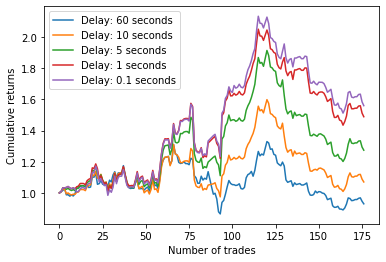

In [290]:
summary = []
tholds = [44]
delays = [60, 10, 5, 1, 0.1]
trade_data = []
for ts in tholds:
    for ds in delays:
        load_path = './trading_results/final_trading_minute_t' + str(ts) + '_d' + str(ds) + '.json'
        data = pd.read_json(load_path)
        data = data.sort_values(by='date_time', ascending=False)      
        cu_bm = [1]
        trades = []
        for l in range (len(data)):
            bm = data.returns_alpha.iloc[l]
            cu_bm.append(cu_bm[l] * bm)
            trades.append(bm)
        summary.append(cu_bm)
        trade_data.append(trades)

##Plot cummulative returns of trading strategy
x_label = []
for i in range (len(summary[0])):
    x_label.append(i)
for g in range (len(summary)):
    labels = 'Delay: ' + str(delays[g]) + ' seconds'
    plt.plot(x_label, summary[g], label=labels)
#plt.plot(x_label, cu_pm, label='Cumulative returns')
#plt.plot(x_label, cu_bm, label='Cumulative returns Jensens alpha adjusted')
#plt.plot(x_label, cu_old, label='Cummulative returns daily data')
plt.ylabel('Cumulative returns')
plt.xlabel('Number of trades')
plt.legend()
plt.show()

In [220]:
trading.Predicted.value_counts()

Up      125
Down    123
Name: Predicted, dtype: int64

Create a histogram of returns

In [287]:
histo = noid
histo['returns_alpha2'] = None
for p in range (len(histo)):
    histo.returns_alpha2.iloc[p] = (np.log(histo.returns_alpha.iloc[p]))
histo = histo.sort_values(by='returns_alpha2', ascending=True)
histo = histo.drop([245])
histo = histo.drop([224])
histo.head(5)

,date_time,text,company,RIC,beta,old_before,old_after,Predicted,id,error,...,time,pre_price,post_price,rm,trade_time,returns_pm,returns_index,returns_alpha,returns_old,returns_alpha2
355,2020-01-30 07:10:00,Förbättrat resultat och starkt kassaflöde – N...,ncc ab,NCCb.ST,0.662338,158.95,168.50,Down,1.58927e+12,NaN,...,25800000000000,152.8,165.65,0.0047184,2020-01-30 09:00:00,0.922427,0.927145,0.925552,0.943323,-0.077365
243,2020-02-06 13:00:00,OKTOBER–DECEMBER 2019 • Försäljning 28 257 ...,securitas ab,SECUb.ST,1.113629,148.45,146.85,Up,1.58894e+12,NaN,...,46800000000000,159.1,147.7,-0.000901352,2020-02-06 13:00:00,0.928347,0.929248,0.929351,0.989222,-0.0732691
455,2020-01-03 08:30:00,INVISIO publicerar en omvänd vinstvarning med ...,invisio communications ab,IVSO.ST,0.164096,102.00,118.20,Up,1.58884e+12,ERROR,...,30600000000000,127,118.2,-0.00533199,2020-01-03 09:00:00,0.930709,0.936041,0.931584,1.15882,-0.0708693
2,2020-02-21 17:15:00,"DETTA PRESSMEDDELANDE FÅR INTE OFFENTLIGGÖRAS,...",ssm holding ab,SSM.ST,2.742974,10.70,12.85,Down,1.58928e+12,NaN,...,62100000000000,10.451,11.15,-0.00100553,2020-02-21 09:00:00,0.937309,0.936304,0.934551,0.832685,-0.0676888
56,2020-02-19 18:00:00,Fjärde kvartalet 2019 · Omsättningen uppgic...,softronic ab,SOFb.ST,0.424380,18.80,19.18,Up,1.58928e+12,NaN,...,0,20.4,19.1,0.0015984,2020-02-20 09:00:00,0.936275,0.934676,0.935596,1.02021,-0.0665713


In [281]:
histo.to_csv('./histo.csv')

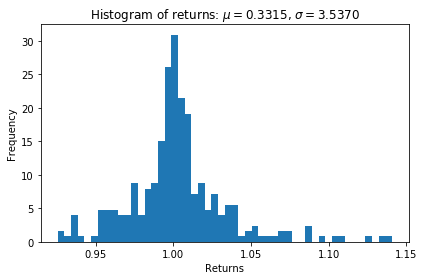

In [289]:
# example data
mu = 0.3315  # mean of distribution
sigma = 3.5370  # standard deviation of distribution
x = histo.returns_alpha

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
 #    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#ax.plot(bins, y, '--')
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
ax.set_title(r'Histogram of returns: $\mu=0.3315$, $\sigma=3.5370$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

(3) Calculate cumulative returns of trading strategy

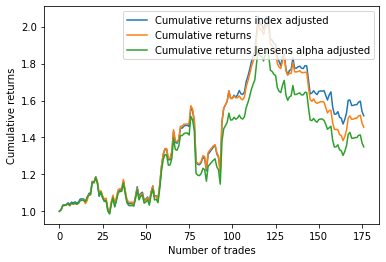

In [275]:
##Calculate cummulative returns of trading strategy
trading = trading.sort_index()
cu_im = [1]
cu_pm = [1]
cu_bm = [1]
cu_old = [1]


for l in range (len(trading)):
    im = trading.returns_index.iloc[l]
    cu_im.append(cu_im[l] * im)
    pm = trading.returns_pm.iloc[l]
    cu_pm.append(cu_pm[l] * pm)
    bm = trading.returns_alpha2.iloc[l] + 1
    cu_bm.append(cu_bm[l] * bm)
    old = trading.returns_old.iloc[l]
    cu_old.append(cu_old[l] * old)


##Plot cummulative returns of trading strategy
x_label = []
for i in range (len(cu_im)):
    x_label.append(i)
plt.plot(x_label, cu_im, label='Cumulative returns index adjusted')
plt.plot(x_label, cu_pm, label='Cumulative returns')
plt.plot(x_label, cu_bm, label='Cumulative returns Jensens alpha adjusted')
#plt.plot(x_label, cu_old, label='Cummulative returns daily data')
plt.ylabel('Cumulative returns')
plt.xlabel('Number of trades')
plt.legend()
plt.show()

(4) Run regression anaylsis 

In [66]:
x = []
y = []
for i in range(len(trading)):
    y.append(trading.returns_pm.iloc[i]-1)
    x.append(trading.rm.iloc[i])
    
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3891
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.534
Time:                        08:43:56   Log-Likelihood:                 180.49
No. Observations:                  88   AIC:                            -357.0
Df Residuals:                      86   BIC:                            -352.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.517      0.6

In [197]:
trading = pd.read_json(load_path)
std = pd.DataFrame()
std['returns_alpha'] = trading['returns_alpha']
std['ra'] = None
for i in range (len(std)):
    std.ra.iloc[i] = (std.returns_alpha.iloc[i] -1)
std.head(5)

,returns_alpha,ra
459,0.982810,-0.01719
458,0.977125,-0.022875
456,1.003309,0.00330924
454,1.008018,0.0080183
452,0.999996,-4.019e-06


In [201]:
results = pd.read_json('./t_results.json')

#results = pd.DataFrame()
#results['prob_threshold'] = None
#results['std']= None
#results['mean'] = None
#results['t_value'] = None
#results['trades'] = None
#results['data'] = None

index = len(results)
print(index)

std_final = std.std(axis=0)
mean = std.ra.mean()
results.loc[index, 'std'] = std_final.ra
results.loc[index,'mean'] = mean
results.loc[index,'t_value'] = (mean * math.sqrt(len(std))) / std_final.ra
results.loc[index, 'prob_threshold'] = threshold
results.loc[index, 'trades'] = len(std)
results.loc[index, 'data'] = 'Minute - ' + str(delay / 1000000000) + ' sec delay'
#results.to_json('./t_results.json')
results = results.sort_index()
results.head(20)

18


,prob_threshold,std,mean,t_value,trades,data
0,50.0,0.036194,0.002284,0.798278,160.0,Hourly
1,45.0,0.035425,0.002848,1.343007,279.0,Hourly
2,33.0,0.037719,0.001995,1.068166,408.0,Hourly
3,60.0,0.039643,-0.003048,-0.461295,36.0,Hourly
4,45.0,0.034203,0.002102,0.784798,163.0,Minute - 1 sec delay
5,45.0,0.028690,-0.000618,-0.275147,163.0,Minute - 60 sec delay
6,45.0,0.034203,0.002102,0.784798,163.0,Minute - 1.0 sec delay
7,45.0,0.034437,0.002287,0.847921,163.0,Minute - 0.1 sec delay
8,44.0,0.034347,0.002837,1.095832,176.0,Minute - 1.0 sec delay
9,44.0,0.034621,0.003112,1.192329,176.0,Minute - 0.1 sec delay
